# NLP: classification task

## Notes

This notebook is a completely finished text classification work in the sense that this laptop contains all the steps necessary for analyzing and training the model, except for collecting raw data, and produces the result.

Each numbered part is essentially a stand-alone notebook. Thus, it is possible to divide this notebook into three parts.

If you are only interested in the classification model, then skip directly to step 3.

# 1) Dataset creation

## Overview

This part is needed to create a raw dataset for the task of classifying sentences by authorship from the original texts. The output will be a csv file in the format: "sentence", "author".

Author list:
- William Shakespeare
- Jane Austen
- Charles Dickens

## File creation

### Packages import

In [1]:
from typing import List
import random

import glob
from nltk import tokenize, download
import numpy as np
import pandas as pd

It is necessary to tokenize the offer, it is enough to call it on the working machine once:

In [2]:
download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\21000\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Function for loading and preprocessing text

Let's create a list of sentences, the length of which is more than 5 characters, since shorter ones, most likely, do not carry information useful for attribution. Generally speaking, these sentences can express, and express quite vividly, the writing style of a particular author; however, this is not used in the model.

To improve the performance of the offer tokenizer, some character combinations are replaced. So, the replicas will be separate from the speech of the author in sentences, and the problem with quotes should be solved.

In [3]:
def split_text(filepath: str, min_char: int = 5) -> List[str]:
    
    text = str()
    with open(filepath, 'r', encoding='utf8') as file:
        text = file.read().replace('\n', '. ')
        text = text.replace('.”', '”.').replace('."', '".').replace('?”', '”?').replace('!”', '”!')
        text = text.replace('--', ' ').replace('. . .', '').replace('_', '')
    
    sentences = tokenize.sent_tokenize(text)    
    sentences = [sentence for sentence in sentences if len(sentence) >= min_char]

    return list(sentences)

### Create a sentence| set for each author

In [5]:
shakespeare = []
for path in glob.glob('input/shakespeare/*.txt'):
    shakespeare += split_text(path)
    
austen = []
for path in glob.glob('input/austen/*.txt'):
    austen += split_text(path)

dickens = []
for path in glob.glob('input/dickens/*.txt'):
    dickens += split_text(path)

In [6]:
text_dict = { 'Shakespeare': shakespeare, 'Austen': austen, 'Dickens': dickens }

for key in text_dict.keys():
    print(key, ':', len(text_dict[key]), ' sentences')

Shakespeare : 11865  sentences
Austen : 44657  sentences
Dickens : 55143  sentences


### Combining sentences

In [7]:
# limit to 10k sentences
np.random.seed(1)

max_len = 10_000

names = [shakespeare, austen, dickens]

combined = []
for name in names:
    name = np.random.choice(name, max_len, replace = False)
    combined += list(name)

print('Length of combo and internally shuffled list:', len(combined))

Length of combo and internally shuffled list: 30000


### Create a marked list

At this point, it is important to indicate the labels of the authors (their names) in the same order as in the previous step, otherwise the data will simply turn out to be incorrect. So far, a simple regulating mechanism does not come to mind.

In [8]:
labels = ['Shakespeare'] * max_len + ['Austen'] * max_len + ['Dickens'] * max_len

print('Length of marked list:', len(labels))

Length of marked list: 30000


The output of the quantity was needed for additional control over the data and their labels. Equality means that every sentence in our dataset will have a label (correct or incorrect - it should have been controlled before).

In [9]:
len(combined) == len(labels)

True

### Randomly shuffle the data

In [10]:
random.seed(3)

zipped = list(zip(combined, labels))
random.shuffle(zipped)
combined, labels = zip(*zipped)

### Exporting the resulting dataset

In [11]:
out_data = pd.DataFrame()
out_data['text'] = combined
out_data['author'] = labels

In [12]:
print(out_data.head())
print(out_data.tail())

                                                text       author
0                 “That’s no question as it stands,.      Dickens
1              And then in post he came from Mantua.  Shakespeare
2  But I will no longer importune my young cousin...       Austen
3              stand by and look at you, dear boy”!.      Dickens
4                       mortally wounded, R.H.U.E.].  Shakespeare
                                                    text       author
29995  Elizabeth was determined; nor did Sir William at.       Austen
29996                                           P. King.  Shakespeare
29997      I told him, moreover, that I believed myself.       Austen
29998                                  on the subject.—.       Austen
29999                                           DUNCAN..  Shakespeare


In [13]:
out_data.to_csv('author_data.csv', index=False)

# 2) Dataset preprocessing

Preparing data for use in model training and explore it.

## Importing packages and loading data

In [14]:
import string
import time

import numpy as np
import pandas as pd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem.porter import PorterStemmer

In [15]:
data = pd.read_csv('author_data.csv', encoding='utf8')
print(data.head())

                                                text       author
0                 “That’s no question as it stands,.      Dickens
1              And then in post he came from Mantua.  Shakespeare
2  But I will no longer importune my young cousin...       Austen
3              stand by and look at you, dear boy”!.      Dickens
4                       mortally wounded, R.H.U.E.].  Shakespeare


In [16]:
text = list(data['text'].values)
author = list(data['author'].values)

print('Dataset contains {} notes.'.format(len(text)))

Dataset contains 30000 notes.


## Data exploration

Number of sentences for each author:

In [17]:
authors = Counter(author)
authors

Counter({'Dickens': 10000, 'Shakespeare': 10000, 'Austen': 10000})

In [18]:
author_names = list(authors.keys())
author_names

['Dickens', 'Shakespeare', 'Austen']

Let's look at some sample sentences:

In [19]:
np.random.seed(73)
n = len(text)

for _ in range(5):
    print(text[np.random.randint(0, n)])

ensconce are constantly used figuratively for hide.
If you will lock the door to secure us from.
And wears upon his baby brow the round.
with so much attention, as to be entirely mistress of the subject.. .
That thou hast done me, therefore turn and draw.. .


## Calculating statistics by words:

In [20]:
word_count = np.array([len(sent.split()) for sent in text])
char_count = np.array([len(sent) for sent in text])
ave_length = char_count / word_count

In [21]:
def get_stats(var):    
    print('\t Min: ', np.min(var))
    print('\t Max: ', np.max(var))
    print('\t Average: ', np.mean(var))
    print('\t Median: ', np.median(var))
    print('\t Percentile 1%: ', np.percentile(var, 1))
    print('\t Percentile 95%: ', np.percentile(var, 95))
    print('\t Percentile 99%: ', np.percentile(var, 99))
    print('\t Percentile 99.5%: ', np.percentile(var, 99.5))
    print('\t Percentile 99.9%: ', np.percentile(var, 99.9))

### Word count

In [22]:
print('Word count statistics:')
get_stats(word_count)

Word count statistics:
	 Min:  1
	 Max:  69
	 Average:  8.148866666666667
	 Median:  8.0
	 Percentile 1%:  1.0
	 Percentile 95%:  15.0
	 Percentile 99%:  23.0
	 Percentile 99.5%:  25.0
	 Percentile 99.9%:  30.00100000000384


C:\Users\21000\AppData\Local\Temp\ipykernel_9608\404985925.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count, kde=True, bins=80).set_title('Distribution of word count in one sentence')


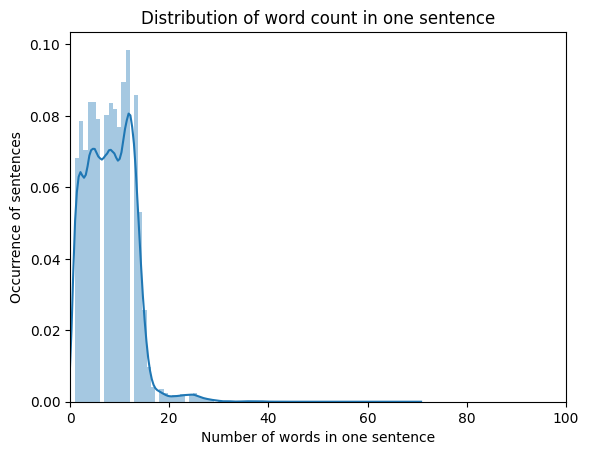

In [23]:
sns.distplot(word_count, kde=True, bins=80).set_title('Distribution of word count in one sentence')
plt.xlabel('Number of words in one sentence') 
plt.ylabel('Occurrence of sentences')
plt.xlim(0, 100)
plt.savefig('word_count.png')
plt.show()

### Character count

In [24]:
print('Character count statistics:')
get_stats(char_count)

Character count statistics:
	 Min:  5
	 Max:  485
	 Average:  44.6465
	 Median:  43.0
	 Percentile 1%:  5.0
	 Percentile 95%:  72.0
	 Percentile 99%:  127.0
	 Percentile 99.5%:  139.0
	 Percentile 99.9%:  147.0


C:\Users\21000\AppData\Local\Temp\ipykernel_9608\655052461.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(char_count, kde=True, bins=80).set_title('Distribution of characters')


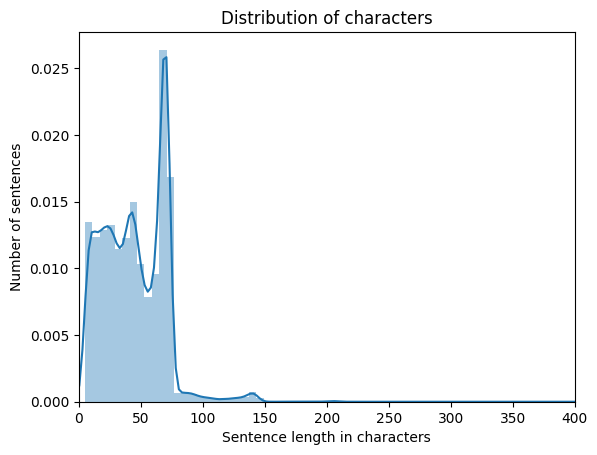

In [25]:
sns.distplot(char_count, kde=True, bins=80).set_title('Distribution of characters')
plt.xlabel('Sentence length in characters')
plt.ylabel('Number of sentences')
plt.xlim(0, 400)
plt.savefig('char_count.png')

### Average length

In [26]:
print('Average length statistics:')
get_stats(ave_length)

Average length statistics:
	 Min:  2.5
	 Max:  36.5
	 Average:  5.66747081440812
	 Median:  5.461538461538462
	 Percentile 1%:  3.6
	 Percentile 95%:  8.0
	 Percentile 99%:  10.333333333333334
	 Percentile 99.5%:  12.0
	 Percentile 99.9%:  15.0


C:\Users\21000\AppData\Local\Temp\ipykernel_9608\2637473181.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ave_length, kde=True, bins=80).set_title('Distribution of average word length')


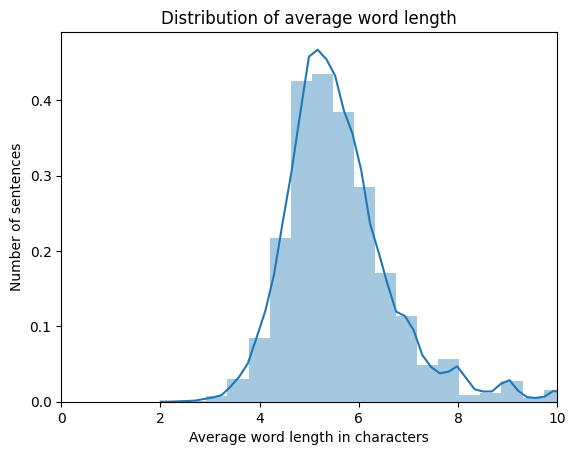

In [27]:
sns.distplot(ave_length, kde=True, bins=80).set_title('Distribution of average word length')
plt.xlabel('Average word length in characters')
plt.ylabel('Number of sentences')
plt.xlim(0, 10)
plt.savefig('ave_length.png')

## Examining outliers in data

### Extremely long sentences

In [28]:
word_outliers = np.where(word_count > 150)

for i in word_outliers[0][:5]:
    print('Author: {}, Sentence length: {}'.format(author[i], word_count[i]))
    print(text[i], '\n')

In [29]:
max_authors = {author : 0 for author in author_names}

for i in word_outliers[0]:
    max_authors[author[i]] += 1

Counter(max_authors)

Counter({'Dickens': 0, 'Shakespeare': 0, 'Austen': 0})

### Extremely short

In [30]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0][:10]:
    print('Sentence length: {}'.format(word_count[i]))
    print(text[i], '\n')

Sentence length: 1
body? 

Sentence length: 1
round. 

Sentence length: 1
Quick”! 

Sentence length: 1
Why?. 

Sentence length: 1
ALL.. 

Sentence length: 1
From. 

Sentence length: 1
Tush! 

Sentence length: 1
reasonable. 

Sentence length: 1
MACDUFF.. 

Sentence length: 1
asleep. 



## Exploring symbols

Let's create a dictionary showing the number of dataset inclusions for each character.

In [31]:
text_string = ''
for sents in text:
    text_string += sents.lower()

char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt), 'unusual symbols in data.')

Counter({' ': 216027, 'e': 127591, 't': 91868, 'o': 81809, 'a': 80450, 'i': 70953, 'n': 70238, 'h': 65707, 's': 63999, 'r': 61383, '.': 44600, 'd': 44245, 'l': 41731, 'u': 30529, 'm': 29491, 'w': 24726, 'c': 24329, 'y': 22703, 'f': 22638, ',': 22048, 'g': 20099, 'p': 16377, 'b': 16153, 'v': 10353, 'k': 8176, '“': 3279, '”': 3269, '’': 3191, ';': 3175, '?': 1716, 'x': 1675, 'j': 1668, ']': 1586, '!': 1566, '—': 1421, 'q': 1215, ':': 1212, '[': 1180, '-': 1139, "'": 625, 'z': 465, '1': 383, '(': 333, ')': 321, '2': 217, '4': 204, '3': 192, '5': 170, '6': 148, '7': 143, '8': 134, '9': 129, '0': 115, '‘': 98, '"': 82, '&': 24, 'é': 23, '}': 16, 'è': 13, '*': 11, 'æ': 8, '/': 6, '{': 4, 'ê': 3, 'ó': 2, 'à': 2, 'á': 2, 'ĕ': 1, 'ī': 1, 'ē': 1, 'ĭ': 1, 'ï': 1, 'œ': 1, '^': 1})
74 unusual symbols in data.


All symbols used:

In [32]:
print(list(char_cnt.keys()))

['“', 't', 'h', 'a', '’', 's', ' ', 'n', 'o', 'q', 'u', 'e', 'i', 'd', ',', '.', 'p', 'c', 'm', 'f', 'r', 'b', 'w', 'l', 'g', 'y', '”', 'k', '!', ']', 'v', 'x', ';', '?', 'j', '[', '5', '4', ':', '7', '8', "'", '—', '-', 'z', '0', '"', '2', '1', '3', '6', '9', 'é', '(', 'è', ')', 'æ', '‘', '/', '*', '}', '&', 'ó', 'ê', 'à', 'á', 'ĕ', 'ī', 'ē', 'ĭ', 'ï', 'œ', '^', '{']


Among them there are many that do not belong to the standard ones, such as punctuation or Cyrillic characters. Let's highlight those sentences in which they occur.

In [35]:
# accented_chars = ['f', 'u', 'r', 's', 'i', 'c', 'h', '́', 'n', 'd', 'p', 'e', 'a', 't', 'o', 'l', 'x', 'm', 'j', 'é', 'ô', 'v', 'q', 'ê', 'g', 'b', 'k', 'y', 'à', 'і', 'z', 'w', 'è', 'ó', 'ö', '°', 'ç', 'ï', 'á', 'ü', 'ù', 'û', 'î', 'ѣ', 'â']

# accented_text = []
# for i in range(len(text)):
#     for j in text[i]:
#         if j in accented_chars:
#             accented_text.append(i)
        
# accented_text = list(set(accented_text))
 
# print(len(accented_text), 'sentences contains unusual symbols.')

In [36]:
# for i in accented_text[:10]:
#     print('Sentence number {}: '.format(i))
#     print(text[i], '\n')

Based on the above research proposals, we can say that our data is quite suitable for analysis. The only thing is that you need to remove the indented blocks and some invalid characters that are artifacts of the original text.

## Data preparation

This is exactly where we remove the unacceptable uninformative characters.

In [ ]:
text = [excerpt.replace('\xa0', '').replace('\x7f', '') for excerpt in text] # remove non‑breaking space and Unicode U+007F

And big blocks of indentation.

In [38]:
ctr = 0
for excerpt in text:
    if '  ' in excerpt:
        ctr += 1

print(ctr, 'occurrences of large blocks of indentation.')

147 occurrences of large blocks of indentation.


In [39]:
new_text = []
for excerpt in text:
    while '  ' in excerpt:
        excerpt = excerpt.replace('  ',' ')
    new_text.append(excerpt)

text = new_text
print(len(text))

30000


Remove punctuation and convert all letters of the sentence to lowercase.

In [40]:
normed_text = []

for sent in text:
    new = sent.lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '') # english quotes
    new = new.replace('‟', '').replace('”', '') # french quotes
    new = new.replace('«', '').replace('»', '') # christmas tree quotes
    new = new.replace('—', '').replace('–', '') # em dash
    new = new.replace('(', '').replace(')', '')
    new = new.replace('…', '') # ellipsis as one character
    
    normed_text.append(new)
    
print(normed_text[0:5])
print(len(normed_text))

['that’s no question as it stands', 'and then in post he came from mantua', 'but i will no longer importune my young cousin ', 'stand by and look at you dear boy', 'mortally wounded rhue']
30000


## Save the prepared data

In [41]:
data['text'] = normed_text

data.to_csv('preprocessed_data.csv', index=False)

In [42]:
#################do it later!!!!!! already copied to the end
####################
#####################
######################
##########################
# # Generate random predictions for the test set
# unique_authors = list(set(author_train))
# random_preds = [random.choice(unique_authors) for _ in range(len(author_test))]

# # Compute accuracy and the confusion matrix
# acc = accuracy_score(author_test, random_preds)
# cm = confusion_matrix(author_test, random_preds, labels=unique_authors)

# print("Random Classification Accuracy: {:.2f}%".format(acc * 100))
# print("Confusion Matrix:")
# print(cm)

# # Plot the confusion matrix (using the function defined earlier)
# plot_confusion_matrix(cm, classes=unique_authors, title="Random Classification Confusion Matrix")
# plt.show()

# Analysys

Teaching and learning models.

## Importing packages and loading pre-prepared data

In [43]:
# %pip install tensorflow

from typing import List

import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import ModelCheckpoint 

from scipy import stats

In [44]:
data = pd.read_csv("preprocessed_data.csv", encoding='utf8')
print(data.head())

                                              text       author
0                  that’s no question as it stands      Dickens
1             and then in post he came from mantua  Shakespeare
2  but i will no longer importune my young cousin        Austen
3                stand by and look at you dear boy      Dickens
4                            mortally wounded rhue  Shakespeare


In [45]:
normed_text = list(data['text'])
author = list(data['author'])

authors_names = list(Counter(author).keys())
authors_count = len(authors_names)

normed_text = [str(i) for i in normed_text]

## Section with statistics and output functions

In [46]:
def plot_confusion_matrix(cm, classes: List[str],
                          normalize: bool = False,
                          title: str = 'Confusion matrix',
                          cmap = plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Unnormalized confusion matrix')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('Right author')
    plt.xlabel('Predicted author')
    plt.title(title)

In [47]:
def plot_history_of_accurancy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model\'s accurancy')
    plt.ylabel('accurancy')
    plt.xlabel('epochs')
    plt.legend(['teaching data', 'test data'], loc='upper left')

In [48]:
def plot_history_of_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model\'s error')
    plt.ylabel('error')
    plt.xlabel('epochs')
    plt.legend(['teaching data', 'test data'], loc='upper left')

## Preparing data for direct use

### We select the training and test set

In [49]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size=0.2, random_state=5)

In [50]:
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(24000,)
(6000,)
(24000,)
(6000,)


### Create n-gram sequences

In [51]:
def create_n_grams(excerpt_list: List[str], n: int, vocab_size: int, seq_size: int):
    n_gram_list = []

    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")

        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        new_string = " ".join(n_grams)

        hot = one_hot(new_string, round(vocab_size * 1.3))

        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [52]:
def get_vocab_size(excerpt_list: List[str], n: int, seq_size: int) -> int:
    n_gram_list = []

    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")
   
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    n_gram_list = list(np.array(n_gram_list).flat)
    
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

Determine the size of the dictionary for n from 1 to 3 inclusive:

In [53]:
vocab_sizes = []
for i in range(1, 4):
    vocab_sizes.append(get_vocab_size(text_train, i, 350))
    print('Size for n =', i, 'is:', vocab_sizes[i - 1])

Size for n = 1 is: 50
Size for n = 2 is: 1097
Size for n = 3 is: 8973


And create lists of n-grams:

In [54]:
gram1_train = create_n_grams(text_train, 1, vocab_sizes[0], 350)
gram2_train = create_n_grams(text_train, 2, vocab_sizes[1], 350)
gram3_train = create_n_grams(text_train, 3, vocab_sizes[2], 350)

In [55]:
gram1_test = create_n_grams(text_test, 1, vocab_sizes[0], 350)
gram2_test = create_n_grams(text_test, 2, vocab_sizes[1], 350)
gram3_test = create_n_grams(text_test, 3, vocab_sizes[2], 350)

In [56]:
print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(24000, 350)
(24000, 350)
(24000, 350)
(6000, 350)
(6000, 350)
(6000, 350)


Определим максимальное значение n-грамм, что будет использовано для создания сети.

In [57]:
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Max value for 1-gramms: ', max_1gram)
print('Max value for bigramms: ', max_2gram)
print('Max value for trigramms: ', max_3gram)

Max value for 1-gramms:  64
Max value for bigramms:  1425
Max value for trigramms:  11664


## Vectorization

In [58]:
processed_train = text_train
processed_test = text_test

print(processed_train[0:5])

['at the same time he hugged his shuddering body in both his', 'awkwardness but their straightforward emotions left no room for the', 'well', 'a couch for luxury113 and damnèd incest', 'besides this duncan']


In [59]:
vectorizer = TfidfVectorizer(strip_accents = 'unicode', min_df = 6)
vectorizer.fit(processed_train)

print('Dictionary size: ', len(vectorizer.vocabulary_))

words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Dictionary size:  2773


In [60]:
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

## Model implementation

https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

In [ ]:
def define_model(input_len: int, output_size: int, vocab_size : int, embedding_dim: int, verbose: bool = True,
                drop_out_pct: float = 0.25, conv_filters: int = 500, activation_fn: str = 'relu', pool_size: int = 2, learning: float = 0.0001):
    inputs1 = Input(shape=(input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters=conv_filters, kernel_size=3, activation=activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size=pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters=conv_filters, kernel_size=4, activation=activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size=pool_size)(conv2)
    flat2 = Flatten()(pool2)
    
    inputs3 = Input(shape=(input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters=conv_filters, kernel_size=5, activation=activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size=pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    merged = concatenate([flat1, flat2, flat3])
    
    output = Dense(output_size, activation='softmax')(merged)
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

Random Classification Accuracy: 33.03%
Normalized confusion matrix
[[0.33181358 0.33383992 0.3343465 ]
 [0.32209361 0.33819829 0.3397081 ]
 [0.3467386  0.3320255  0.3212359 ]]


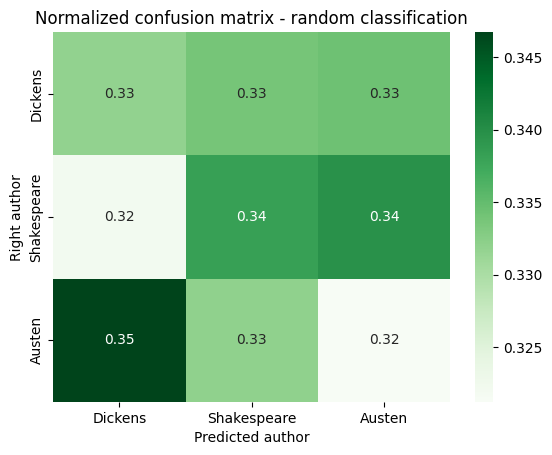

In [ ]:
random_preds = [random.choice(authors_names) for _ in range(len(author_test))]
acc = accuracy_score(author_test, random_preds)
print("Random Classification Accuracy: {:.2f}%".format(acc * 100))

confusion = confusion_matrix(author_test, random_preds, labels=authors_names)

plot_confusion_matrix(confusion, classes=authors_names, normalize=True, title='Normalized confusion matrix - random classification')
plt.savefig('confusion_model_random.png')

## Calculations

In [ ]:
gram1_model = define_model(350, authors_count, max_1gram + 1, 26)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 350, 26)   │      1,690 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 350, 26)   │      1,690 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 350, 26)   │      1,690 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 350, 26)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 350, 26)   │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 350, 26)   │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 348, 500)  │     39,500 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 347, 500)  │     52,500 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 346, 500)  │     65,500 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 174, 500)  │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 173, 500)  │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 173, 500)  │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 87000)     │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 86500)     │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 86500)     │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 260000)    │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 942,573 (3.60 MB)

 Trainable params: 942,573 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
gram1_model_history = gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.4256 - loss: 1.0425 - val_accuracy: 0.4754 - val_loss: 0.9905
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.4756 - loss: 0.9907 - val_accuracy: 0.5123 - val_loss: 0.9761
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5140 - loss: 0.9576 - val_accuracy: 0.5269 - val_loss: 0.9495
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5313 - loss: 0.9373 - val_accuracy: 0.5358 - val_loss: 0.9342
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5541 - loss: 0.9114 - val_accuracy: 0.5523 - val_loss: 0.9170
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5734 - loss: 0.8879 - val_accuracy: 0.5596 - val_loss: 0.9070
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.5790 - loss: 0.8734 - val_accuracy: 0.5612 - val_loss: 0.8987
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.5926 - loss: 0.8544 - 

In [ ]:
gram2_model = define_model(350, authors_count, max_2gram + 1, 300)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 350, 300)  │    427,200 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 350, 300)  │    427,200 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 350, 300)  │    427,200 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 350, 300)  │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 350, 300)  │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 350, 300)  │          0 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 348, 500)  │    450,500 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 347, 500)  │    600,500 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 346, 500)  │    750,500 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 174, 500)  │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 173, 500)  │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 173, 500)  │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 87000)     │          0 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 86500)     │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 86500)     │          0 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 260000)    │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,863,103 (14.74 MB)

 Trainable params: 3,863,103 (14.74 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
gram2_model_history = gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 104s 172ms/step - accuracy: 0.4393 - loss: 1.0324 - val_accuracy: 0.5498 - val_loss: 0.9179
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 104s 174ms/step - accuracy: 0.5939 - loss: 0.8524 - val_accuracy: 0.6263 - val_loss: 0.8147
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 119s 199ms/step - accuracy: 0.6662 - loss: 0.7475 - val_accuracy: 0.6452 - val_loss: 0.7785
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 127s 211ms/step - accuracy: 0.6985 - loss: 0.6831 - val_accuracy: 0.6465 - val_loss: 0.7662
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 125s 209ms/step - accuracy: 0.7278 - loss: 0.6354 - val_accuracy: 0.6552 - val_loss: 0.7585
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 117s 195ms/step - accuracy: 0.7600 - loss: 0.5840 - val_accuracy: 0.6581 - val_loss: 0.7495
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 112s 187ms/step - accuracy: 0.7835 - loss: 0.5395 - val_accuracy: 0.6531 - val_loss: 0.7602
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 128s 213ms/step - accuracy: 0.8081 -

In [ ]:
t0 = time.time()
gram3_model = define_model(350, authors_count, max_3gram + 1, 600)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 350)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 350, 600)  │  6,999,000 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 350, 600)  │  6,999,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 350, 600)  │  6,999,000 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 350, 600)  │          0 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 350, 600)  │          0 │ embedding_10[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 350, 600)  │          0 │ embedding_11[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 348, 500)  │    900,500 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 347, 500)  │  1,200,500 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 346, 500)  │  1,500,500 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 174, 500)  │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 173, 500)  │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 173, 500)  │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 87000)     │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 86500)     │          0 │ max_pooling1d_10… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 86500)     │          0 │ max_pooling1d_11… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 25,378,503 (96.81 MB)

 Trainable params: 25,378,503 (96.81 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
gram3_model_history = gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=10, batch_size=32, 
                verbose=1, validation_split=0.2)
t1 = time.time()

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 251s 417ms/step - accuracy: 0.4411 - loss: 1.0290 - val_accuracy: 0.6388 - val_loss: 0.8267
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 251s 418ms/step - accuracy: 0.6948 - loss: 0.7099 - val_accuracy: 0.6965 - val_loss: 0.6752
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 234s 389ms/step - accuracy: 0.7872 - loss: 0.5070 - val_accuracy: 0.7067 - val_loss: 0.6575
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 253s 421ms/step - accuracy: 0.8405 - loss: 0.3978 - val_accuracy: 0.7154 - val_loss: 0.6782
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 246s 410ms/step - accuracy: 0.8914 - loss: 0.3130 - val_accuracy: 0.7110 - val_loss: 0.7222
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 266s 443ms/step - accuracy: 0.9284 - loss: 0.2227 - val_accuracy: 0.7073 - val_loss: 0.7855
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 252s 420ms/step - accuracy: 0.9532 - loss: 0.1622 - val_accuracy: 0.6998 - val_loss: 0.8548
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 273s 455ms/step - accuracy: 0.9712 -

## 3-gramm first model statistics

In [ ]:
author_pred1 = gram1_model.predict([gram1_test, gram1_test, gram1_test])

t2 = time.time()

author_pred1 = author_lb.inverse_transform(author_pred1)

accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels=authors_names)
    
print('Accurancy:', accuracy)
print('Average Precision:', ave_precision)
print('Average Recall:', ave_recall)
print('Average F1 Score:', ave_f1)
print('Learning time:', (t1 - t0), 'seconds')
print('Prediction time:', (t2 - t1), 'seconds')
print('Confusion matrix:\n', confusion)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Accurancy: 0.5573333333333333
Average Precision: 0.5518068663556878
Average Recall: 0.5573333333333332
Average F1 Score: 0.5517350378215032
Learning time: 2540.328337430954 seconds
Prediction time: 773.5971615314484 seconds
Confusion matrix:
 [[ 831  508  635]
 [ 301 1413  273]
 [ 509  430 1100]]


Normalized confusion matrix
[[0.42097264 0.25734549 0.32168186]
 [0.15148465 0.71112229 0.13739305]
 [0.24963217 0.21088769 0.53948014]]


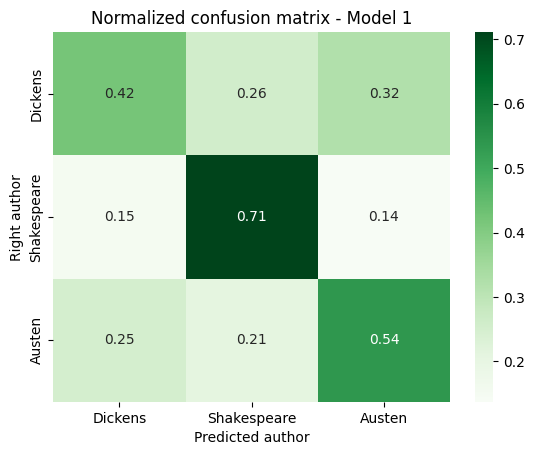

In [ ]:
plot_confusion_matrix(confusion, classes=authors_names, \
                      normalize=True, title='Normalized confusion matrix - Model 1')

plt.savefig('confusion_model1.png')

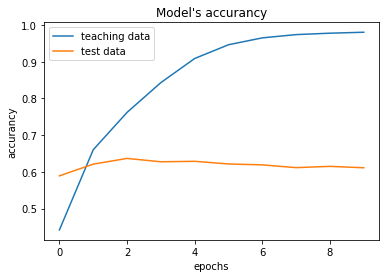

In [ ]:
plot_history_of_accurancy(gram3_model_history)
plt.savefig('accurancy_model1.png')

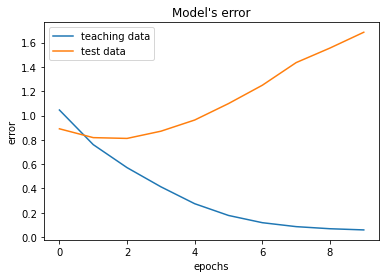

In [ ]:
plot_history_of_loss(gram3_model_history)
plt.savefig('loss_model1.png')

In [ ]:
keras.utils.plot_model(gram3_model, 'gram3_model1_arh.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


The trigram model showed the best results in terms of accuracy, so you should choose it as the main one.

The improved version should only be trained for 5 epochs, because the graph shows a plateau and even a decline in model accuracy after this point.

## Improvement

Retraining the trigram model with the addition of an additional channel.

In [ ]:
def define_model2(input_len: int, output_size: int, vocab_size: int, embedding_dim: int, verbose: bool = True,
                drop_out_pct: float = 0.25, conv_filters: int = 500, activation_fn: str = 'relu', pool_size:int = 2, learning: float = 0.0001):
    
    inputs1 = Input(shape=(input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters=conv_filters, kernel_size=3, activation=activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size=pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters=conv_filters, kernel_size=4, activation=activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size=pool_size)(conv2)
    flat2 = Flatten()(pool2)

    inputs3 = Input(shape=(input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters=conv_filters, kernel_size=5, activation=activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size=pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    inputs4 = Input(shape=(input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters=conv_filters, kernel_size=6, activation=activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size=pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    output = Dense(output_size, activation='softmax')(merged)
    
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [ ]:
t0 = time.time()
gram3_model2 = define_model2(350, authors_count, max_3gram + 1, 600)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 350)]        0                                            
____________________________________________________________________________________________

In [ ]:
gram3_model2_history = gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
                verbose=1, validation_split=0.2)
t1 = time.time()

Epoch 1/5
1200/1200 [==============================] - 1570s 1s/step - loss: 1.0875 - accuracy: 0.3934 - val_loss: 0.8853 - val_accuracy: 0.5809
Epoch 2/5
1200/1200 [==============================] - 1535s 1s/step - loss: 0.7500 - accuracy: 0.6665 - val_loss: 0.8046 - val_accuracy: 0.6256
Epoch 3/5
1200/1200 [==============================] - 1543s 1s/step - loss: 0.5314 - accuracy: 0.7890 - val_loss: 0.8213 - val_accuracy: 0.6309
Epoch 4/5
1200/1200 [==============================] - 1550s 1s/step - loss: 0.3560 - accuracy: 0.8778 - val_loss: 0.8906 - val_accuracy: 0.6254
Epoch 5/5
1200/1200 [==============================] - 1543s 1s/step - loss: 0.2158 - accuracy: 0.9371 - val_loss: 1.0399 - val_accuracy: 0.6186


In [ ]:
author_pred2 = gram3_model2.predict([gram3_test, gram3_test, gram3_test, gram3_test])

t2 = time.time()

author_pred2 = author_lb.inverse_transform(author_pred2)

accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support=score(author_test, author_pred2)
ave_precision = np.average(precision, weights=support/np.sum(support))
ave_recall = np.average(recall, weights=support/np.sum(support))
ave_f1 = np.average(f1, weights=support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels=authors_names)
    
print('Accurancy:', accuracy)
print('Average Precision:', ave_precision)
print('Average Recall:', ave_recall)
print('Average F1 Score:', ave_f1)
print('Learning time:', (t1 - t0), 'seconds')
print('Predict time:', (t2 - t1), 'seconds')
print('Confusion matrix:\n', confusion)

Accurancy: 0.612
Average Precision: 0.6141909673925585
Average Recall: 0.612
Average F1 Score: 0.6116357016728957
Learning time: 7763.147629261017 seconds
Predict time: 37.38660550117493 seconds
Confusion matrix:
 [[2561  887  605]
 [ 726 2519  660]
 [ 869  909 2264]]


Normalized confusion matrix
[[0.63187762 0.21885023 0.14927214]
 [0.18591549 0.64507042 0.16901408]
 [0.21499258 0.22488867 0.56011875]]


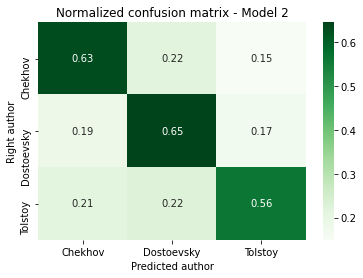

In [ ]:
plot_confusion_matrix(confusion, classes=authors_names, \
                      normalize=True, title='Normalized confusion matrix - Model 2')

plt.savefig('confusion_model2.png')

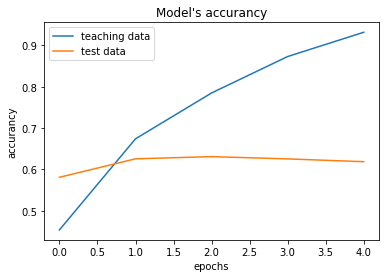

In [ ]:
plot_history_of_accurancy(gram3_model2_history)
plt.savefig('accurancy_model2.png')

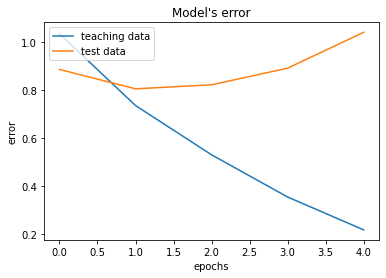

In [ ]:
plot_history_of_loss(gram3_model2_history)
plt.savefig('loss_model2.png')

In [ ]:
keras.utils.plot_model(gram3_model2, 'gram3_model2_arh.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# 4*) Benchmarks and comparation

In [ ]:
accuracy_list = []
prec_list = []
recall_list = []
f1_list = []

for i in range(10):
    author_pred3 = np.random.choice(authors_names, len(author_test))

    accuracy = accuracy_score(author_test, author_pred3)
    precision, recall, f1, support = score(author_test, author_pred3)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print('Accurancy:', accuracy_list, np.mean(accuracy_list), np.std(accuracy_list))
print('Average Precision:', prec_list, np.mean(prec_list), np.std(prec_list))
print('Average Recall:', recall_list, np.mean(recall_list), np.std(recall_list))
print('Average F1 Score:', f1_list, np.mean(f1_list), np.std(f1_list))

Accurancy: [0.33075, 0.334, 0.32708333333333334, 0.328, 0.33441666666666664, 0.3383333333333333, 0.32975, 0.334, 0.33316666666666667, 0.33475] 0.332425 0.003284316688614404
Average Precision: [0.33085190837710243, 0.33401052238064466, 0.3272698811766318, 0.328127324687212, 0.3346487371029293, 0.33851232302357154, 0.32986365042926846, 0.33400214396896677, 0.33322706543031516, 0.33472658477555006] 0.33252401413521926 0.0032699346799768014
Average Recall: [0.33075000000000004, 0.334, 0.3270833333333333, 0.328, 0.3344166666666667, 0.3383333333333334, 0.32975, 0.33399999999999996, 0.33316666666666667, 0.33475] 0.332425 0.0032843166886144214
Average F1 Score: [0.3307730370665397, 0.3339836976105784, 0.32711396699034023, 0.3280459727271682, 0.3344503654553463, 0.338356615375229, 0.3297219223483271, 0.3339362480148582, 0.3330336010360224, 0.3347280451165189] 0.33241434717409285 0.0032724824522703017


In [ ]:
for i in range(100):
    print('Sentence', i, '- Right answer =', author_test[i],  'Model\'s 1 predict =', author_pred1[i], 
         'Model\'s 2 predict =', author_pred2[i])
    print(text_test[i], '\n')

Sentence 0 - Right answer = Dostoevsky Model's 1 predict = Dostoevsky Model's 2 predict = Dostoevsky
он намекал на ее исцеление об этом конечно говорить еще рано 

Sentence 1 - Right answer = Dostoevsky Model's 1 predict = Chekhov Model's 2 predict = Tolstoy
в то же самое мгновение заметил он что приятель его пробирается уже на крыльцо и вероятно к олсуфью ивановичу 

Sentence 2 - Right answer = Tolstoy Model's 1 predict = Chekhov Model's 2 predict = Chekhov
 ну митрий андреич спаси тебя бог 

Sentence 3 - Right answer = Chekhov Model's 1 predict = Chekhov Model's 2 predict = Chekhov
 откуда же этот экипаж взялся 

Sentence 4 - Right answer = Tolstoy Model's 1 predict = Tolstoy Model's 2 predict = Tolstoy
я правду говору улыбаясь сказал гусар всё о войне через стол прокричал граф 

Sentence 5 - Right answer = Dostoevsky Model's 1 predict = Dostoevsky Model's 2 predict = Dostoevsky
расстается навеки  постой не кричи тетка не любит 

Sentence 6 - Right answer = Tolstoy Model's 1 predict 

In [ ]:
def calculate_averages(true, pred, text):
    
    correct_len_chars = []
    incorrect_len_chars = []
    correct_len_words = []
    incorrect_len_words = []

    
    for i in range(len(true)):
        if true[i] == pred[i]:
            correct_len_chars.append(len(text[i]))
            correct_len_words.append(len(text[i].split()))
        else:
            incorrect_len_chars.append(len(text[i]))
            incorrect_len_words.append(len(text[i].split()))
    
    correct_ave_chars = np.mean(correct_len_chars)
    correct_ave_words = np.mean(correct_len_words)
    incorrect_ave_chars = np.mean(incorrect_len_chars)
    incorrect_ave_words = np.mean(incorrect_len_words)
    
    print('t-test for characters')
    print(stats.ttest_ind(correct_len_chars, incorrect_len_chars, equal_var = False))
    
    print('\nt-test for words')
    print(stats.ttest_ind(correct_len_words, incorrect_len_words, equal_var = False))
    
    return correct_ave_chars, correct_ave_words, incorrect_ave_chars, incorrect_ave_words

In [ ]:
correct_ave_chars1, correct_ave_words1, incorrect_ave_chars1, incorrect_ave_words1\
= calculate_averages(author_test, author_pred1, text_test)

t-test for characters
Ttest_indResult(statistic=13.100791149616805, pvalue=6.154725368934383e-39)

t-test for words
Ttest_indResult(statistic=12.716836553257187, pvalue=8.39541625242608e-37)


In [ ]:
correct_ave_chars2, correct_ave_words2, incorrect_ave_chars2, incorrect_ave_words2\
= calculate_averages(author_test, author_pred2, text_test)

t-test for characters
Ttest_indResult(statistic=14.774104146059196, pvalue=5.970280702831298e-49)

t-test for words
Ttest_indResult(statistic=14.375577701430858, pvalue=1.843813497336129e-46)


In [ ]:
print('Model 1 - Average length correct predicted sentences by characters =', correct_ave_chars1, 
        ', incorrect =', incorrect_ave_chars1)
print('Model 2 - Average length correct predicted sentences by characters =', correct_ave_chars2, 
      ', incorrect =', incorrect_ave_chars2)

print('\nModel 1 - Average length correct predicted sentences by words =', correct_ave_words1, 
        ', incorrect =', incorrect_ave_words1)
print('Model 2 - Average length correct predicted sentences by words =', correct_ave_words2, 
      ', incorrect =', incorrect_ave_words2)

Model 1 - Average length correct predicted sentences by characters = 93.35714285714286 , incorrect = 72.11407160699417
Model 2 - Average length correct predicted sentences by characters = 94.01892701525054 , incorrect = 70.39497422680412

Model 1 - Average length correct predicted sentences by words = 15.606170094496942 , incorrect = 12.25
Model 2 - Average length correct predicted sentences by words = 15.71541394335512 , incorrect = 11.971005154639176


# **baseline**: random predict

Random Classification Accuracy: 33.38%
Confusion Matrix:
[[710 690 639]
 [636 675 663]
 [689 680 618]]
Unnormalized confusion matrix
[[710 690 639]
 [636 675 663]
 [689 680 618]]


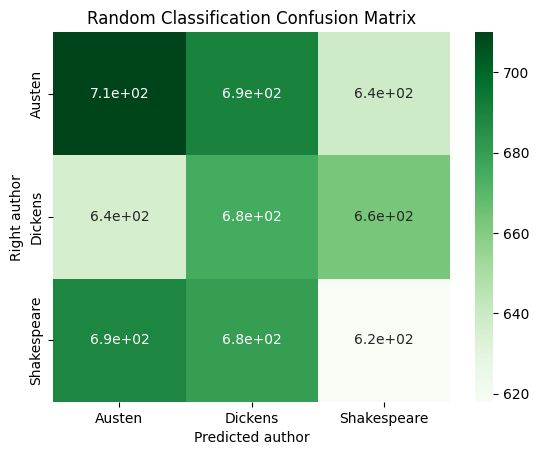

In [ ]:
# Generate random predictions for the test set
unique_authors = list(set(author_train))
random_preds = [random.choice(unique_authors) for _ in range(len(author_test))]

# Compute accuracy and the confusion matrix
acc = accuracy_score(author_test, random_preds)
cm = confusion_matrix(author_test, random_preds, labels=unique_authors)

print("Random Classification Accuracy: {:.2f}%".format(acc * 100))
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix (using the function defined earlier)
plot_confusion_matrix(cm, classes=unique_authors, title="Random Classification Confusion Matrix")
plt.show()

Normalized confusion matrix
[[0.34820991 0.33840118 0.31338892]
 [0.32218845 0.34194529 0.33586626]
 [0.3467539  0.34222446 0.31102164]]


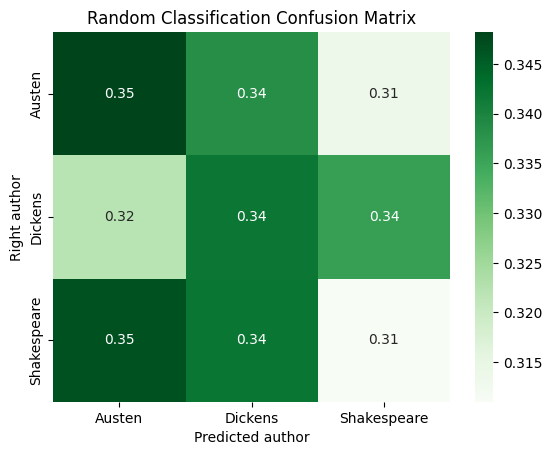

In [62]:
# plot by accuracy rate, instead of occurance
plot_confusion_matrix(cm, classes=unique_authors, normalize=True, title="Random Classification Confusion Matrix")